In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




In [2]:
! pip install git+https://github.com/openai/CLIP.git



  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-f2qow6xa
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-f2qow6xa
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=25617594ac863a74703d732277e9745ab52d541fb55278a403a1a1d48f9e0810
  Stored in directory: /tmp/pip-ephem-wheel-cache-u7ngsa72/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [7]:

import clip
from tqdm import tqdm

model, preprocess = clip.load('RN50')

def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

templates=["This is a photo of {}."]
zeroshot_weights = zeroshot_classifier(classes, templates)

100%|██████████| 10/10 [00:01<00:00,  7.74it/s]


In [8]:


# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [13]:
clip_labels = [f"This is a photo of a {label}" for label in classes]
print(clip_labels)

['This is a photo of a plane', 'This is a photo of a car', 'This is a photo of a bird', 'This is a photo of a cat', 'This is a photo of a deer', 'This is a photo of a dog', 'This is a photo of a frog', 'This is a photo of a horse', 'This is a photo of a ship', 'This is a photo of a truck']


In [15]:
preds=[]
all_labels = []
for image, class_id in testset:
    image_input = preprocess(image).unsqueeze(0)
    with torch.no_grad():
      features = model.encode_image(image_input.to("cuda"))
      features /= features.norm(dim=-1, keepdim=True)

      similarity = (100.0 * features @ zeroshot_weights)
      probs = similarity.softmax(dim=-1)

      _, pred = torch.max(probs, 1)
      preds.append(pred)
      all_labels.append(class_id)

NameError: name 'image_features' is not defined

In [16]:
preds=np.array([pred[0].item() for pred in preds])
all_labels=np.array(all_labels)

Classification Report:
              precision    recall  f1-score   support

       plane       0.82      0.82      0.82      1000
         car       0.61      0.99      0.75      1000
        bird       0.38      0.91      0.54      1000
         cat       0.81      0.50      0.61      1000
        deer       0.83      0.54      0.66      1000
         dog       0.74      0.59      0.66      1000
        frog       0.92      0.41      0.57      1000
       horse       0.74      0.84      0.79      1000
        ship       0.92      0.74      0.82      1000
       truck       0.97      0.54      0.69      1000

    accuracy                           0.69     10000
   macro avg       0.77      0.69      0.69     10000
weighted avg       0.77      0.69      0.69     10000



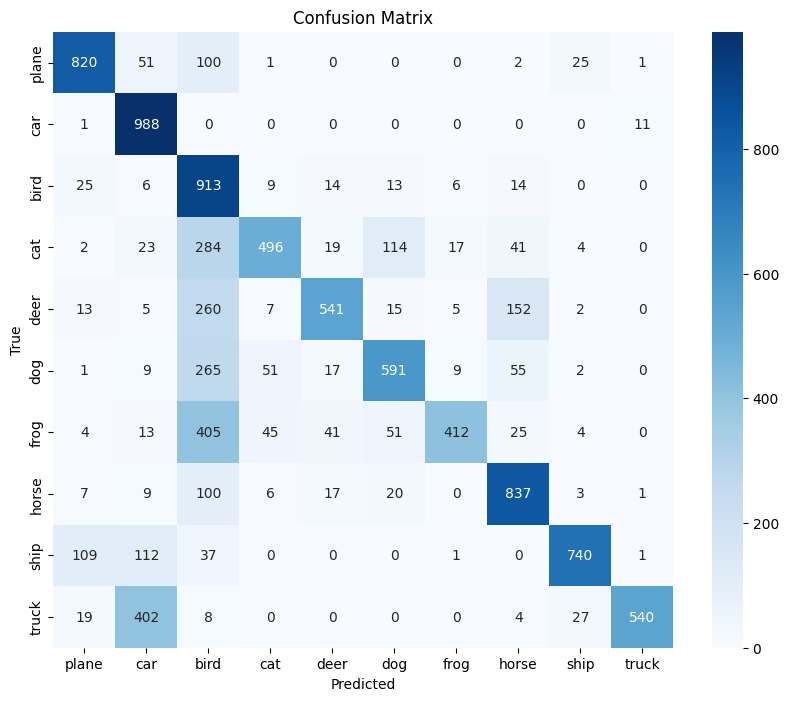

Accuracy for class: plane is 82.0 %
Accuracy for class: car   is 98.8 %
Accuracy for class: bird  is 91.3 %
Accuracy for class: cat   is 49.6 %
Accuracy for class: deer  is 54.1 %
Accuracy for class: dog   is 59.1 %
Accuracy for class: frog  is 41.2 %
Accuracy for class: horse is 83.7 %
Accuracy for class: ship  is 74.0 %
Accuracy for class: truck is 54.0 %
Overall Accuracy: 68.78%


In [17]:


# Classification Report
print("Classification Report:")
print(classification_report(all_labels, preds, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Class-wise Accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

for label, prediction in zip(all_labels, preds):
    if label == prediction:
        correct_pred[classes[label]] += 1
    total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# Overall Accuracy
total_correct = sum(correct_pred.values())
total_samples = sum(total_pred.values())
overall_accuracy = 100 * total_correct / total_samples
print(f"Overall Accuracy: {overall_accuracy:.2f}%")